In [1]:
import csv
import sys
import pandas as pd
from numpy import nanmedian
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
metric_names = {
    'changes_size': 'Code churn',
    'test_changes_size': 'Test churn',
    'code_churn_overall': 'Prior changes',
    'LOC': 'LOC',
    'avg_cyclomatic': 'Average cyclomatic',
    'cnt_func': 'Number of functions',
    'maxnesting': 'Maximum nesting',
    'ratio_comment': 'Comment ratio',
    'modules_num': 'Module number',
    'page_rank': 'PageRank',
    'betweenness': 'Betweenness',
    'closeness': 'Closeness',
    'developer_familiarity_overall': 'Developer exp.',
    'reviewer_familiarity_overall': 'Reviewer exp.',
    'comments': 'Number of comments',
    'comment_words': 'Comment words',
    'review_duration': 'Review duration',
    'min_neg': 'Developer sentiment',
    'owner_neg': 'Owner sentiment',
    'landing_delta': 'Landing delta',
    'response_delta': 'Response delta',
    'release_delta': 'Release delta',
}

In [3]:
def loadMetrics():
    with open('../metric_list.txt') as f:
        return [line.rstrip('\n') for line in f]

In [4]:
def loadData():
    df_aurora = pd.read_csv('../independent_metrics/basic_aurora.csv')
    df_beta = pd.read_csv('../independent_metrics/basic_beta.csv')
    df_release = pd.read_csv('../independent_metrics/basic_release.csv')
    df_review = pd.read_csv('../independent_metrics/review_metrics.csv')
    df_src = pd.read_csv('../independent_metrics/src_code_metrics.csv')
    df_senti = pd.read_csv('../independent_metrics/senti_metrics.csv')
#    df_basic = pd.concat([df_aurora, df_beta, df_release]).drop_duplicates()
    df_basic = df_beta
    df = pd.merge(df_basic, df_review, on='bug_id')
    df = pd.merge(df, df_senti, on='bug_id')
    df = pd.merge(df, df_src, on='bug_id')
    # Convert deltas from seconds to days.
    df.landing_delta = df.landing_delta / 86400
    df.response_delta = df.response_delta / 86400
    df.release_delta = df.release_delta / 86400
    # Ignore uplifts in the 'Pocket' component.
    df = df[df.component != 'Pocket']
    return df

In [5]:
def subCategories(df, df_input, tag, value):
    df = pd.merge(df_input, df, on='bug_id')
    df_sub1 = df[df[tag] == value]
    df_sub2 = df[df[tag] != value]
    return df_sub1, df_sub2

In [6]:
def bonferroniCorrection(p_value, num_tests):
    if p_value * num_tests < 1:
        return p_value * num_tests
    return 1

In [7]:
def outputResults(df_sub1, df_sub2, cat1):
    output_list = list()
    for metric in metric_list:
        sub1_median = nanmedian(df_sub1[metric])
        sub2_median = nanmedian(df_sub2[metric])
        
        #print([df_sub1[metric], df_sub2[metric]])
                
        plt.boxplot([df_sub1[metric], df_sub2[metric].dropna()], showfliers=False, labels=[cat1, 'others'])
        plt.title(metric_names[metric])
        plt.show()
        
        statistic,p_value = stats.mannwhitneyu(df_sub1[metric], df_sub2[metric])
        corrected_p = bonferroniCorrection(p_value, 22)
        
        output_list.append([metric_names[metric], sub1_median, sub2_median, corrected_p])
        
    print (pd.DataFrame(output_list, columns=['metric', cat1, 'others', 'p-value']).round(2))
    return

In [8]:
df = loadData()
metric_list = loadMetrics()

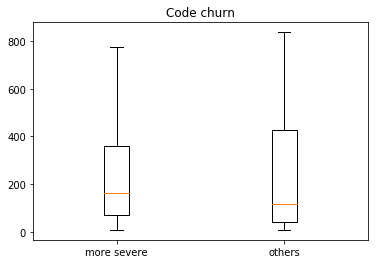

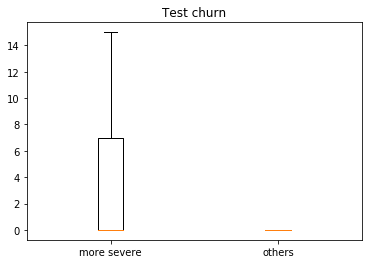

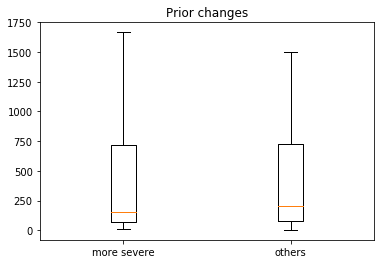

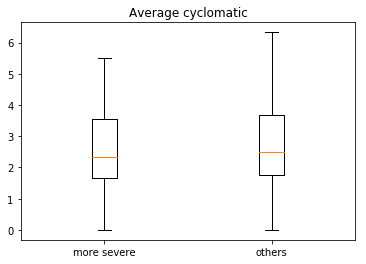

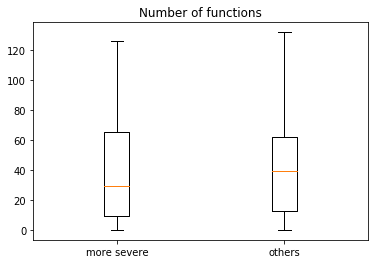

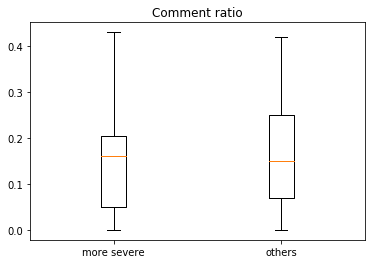

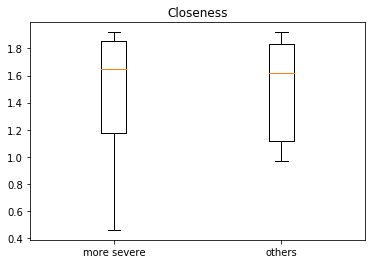

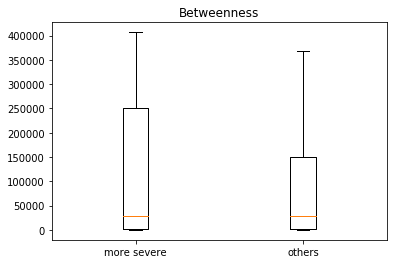

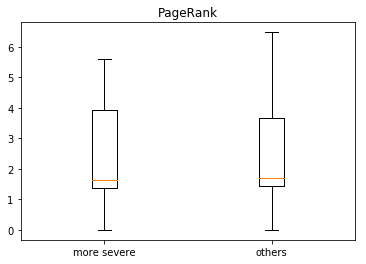

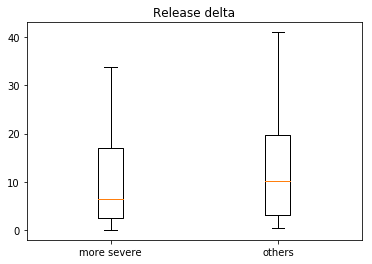

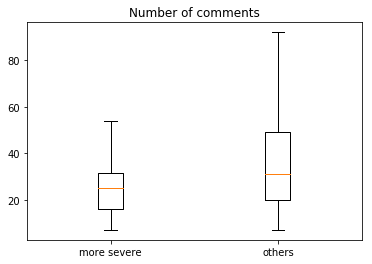

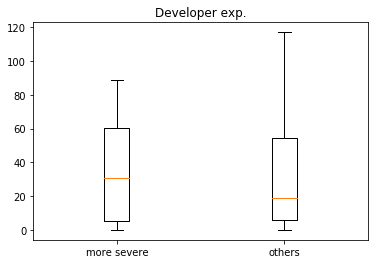

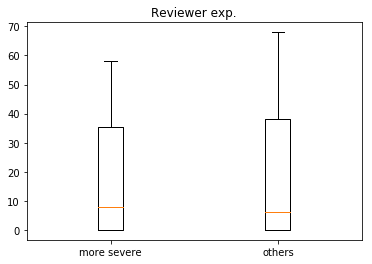

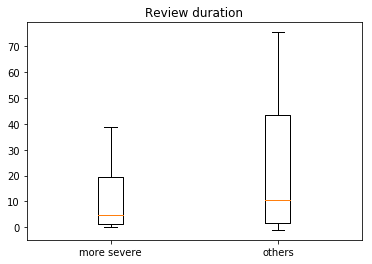

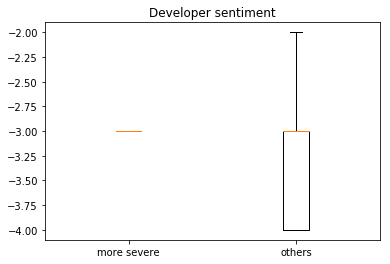

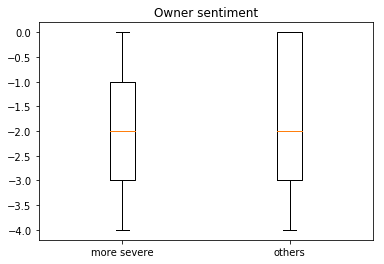

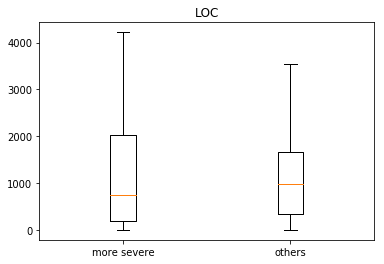

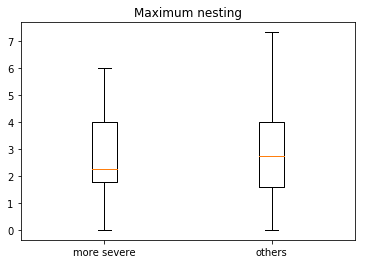

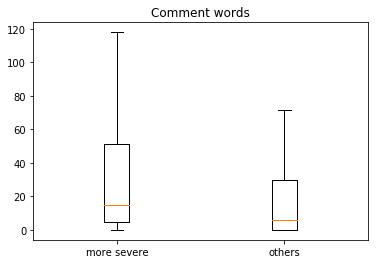

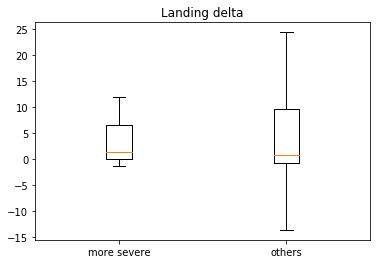

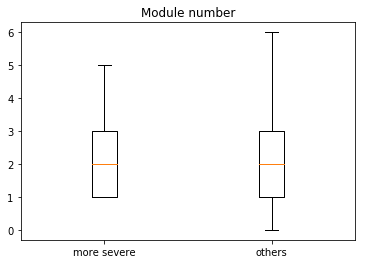

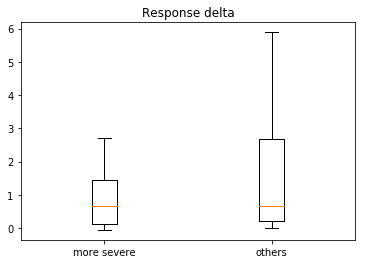

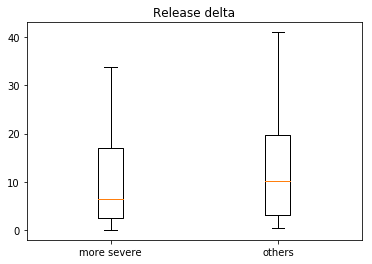

                 metric  more severe    others  p-value
0            Code churn       161.00    118.50     1.00
1            Test churn         0.00      0.00     1.00
2         Prior changes       150.00    202.50     1.00
3    Average cyclomatic         2.33      2.50     1.00
4   Number of functions        29.44     39.13     1.00
5         Comment ratio         0.16      0.15     1.00
6             Closeness         1.65      1.62     1.00
7           Betweenness     27770.83  27793.18     1.00
8              PageRank         1.64      1.70     1.00
9         Release delta         6.43     10.08     1.00
10   Number of comments        25.00     31.00     0.77
11       Developer exp.        31.00     19.00     1.00
12        Reviewer exp.         8.00      6.00     1.00
13      Review duration         4.95     10.48     1.00
14  Developer sentiment        -3.00     -3.00     1.00
15      Owner sentiment        -2.00     -2.00     1.00
16                  LOC       745.00    983.88  

In [9]:
df_input = pd.read_csv('severity_beta.csv')
#df_release = pd.read_csv('severity_release.csv')
#df_input = pd.concat([df_beta, df_release]).drop_duplicates()
df_input = df_input[df_input['Severity'].notnull()]
df_input.rename(columns={'Uplift ID':'bug_id'}, inplace=True)

df_sub1, df_sub2 = subCategories(df, df_input, 'Severity', 'R')
outputResults(df_sub1, df_sub2, 'more severe')

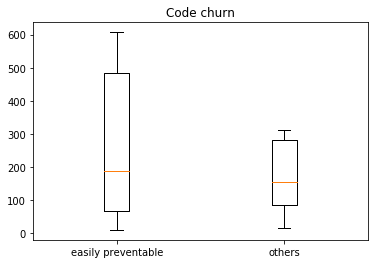

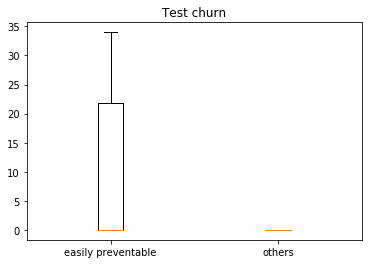

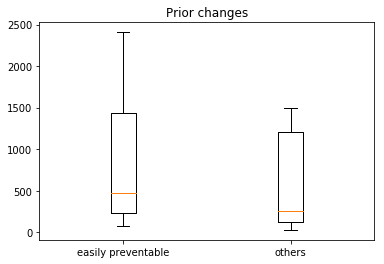

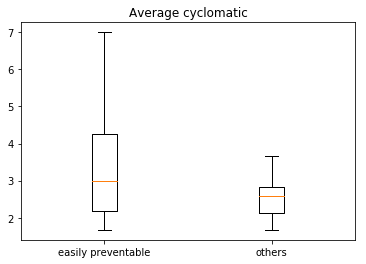

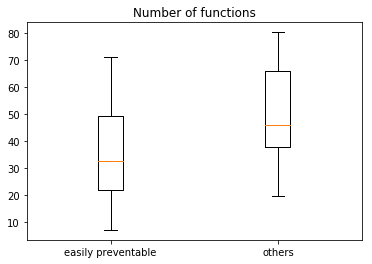

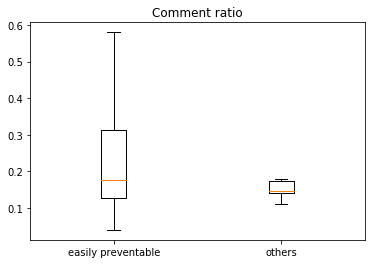

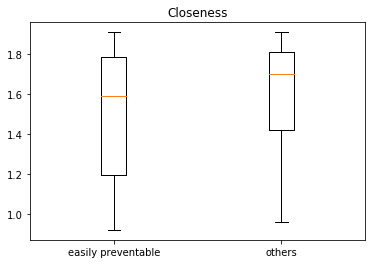

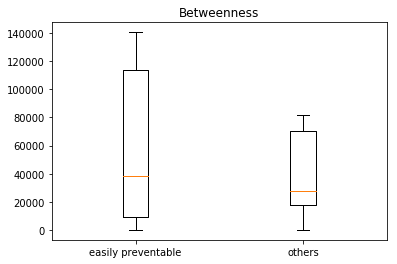

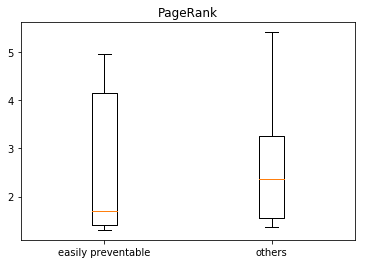

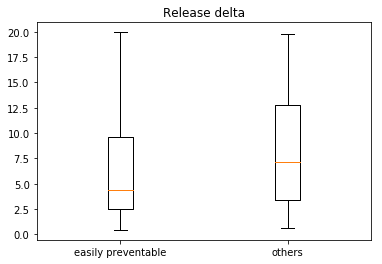

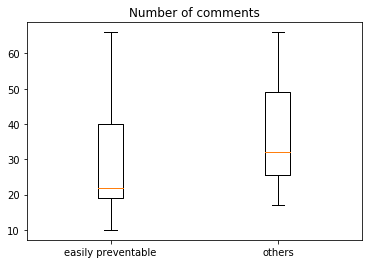

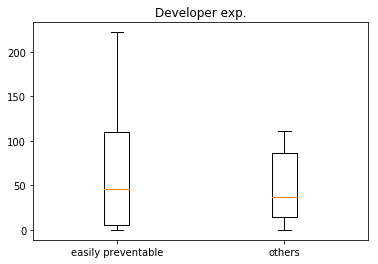

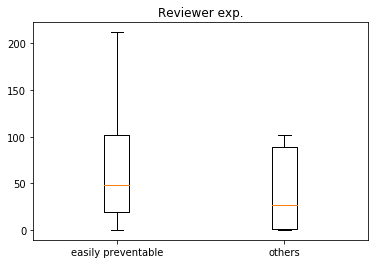

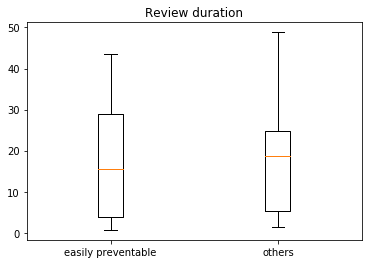

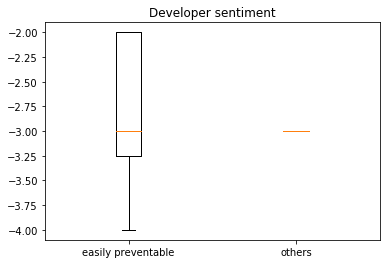

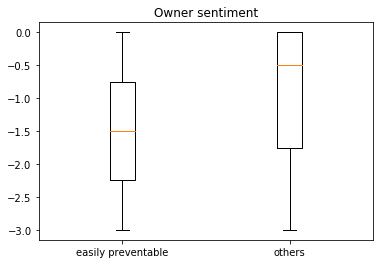

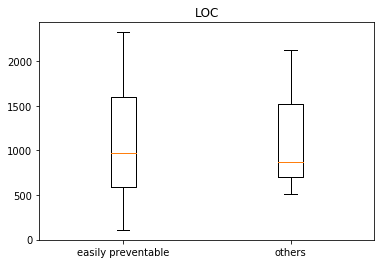

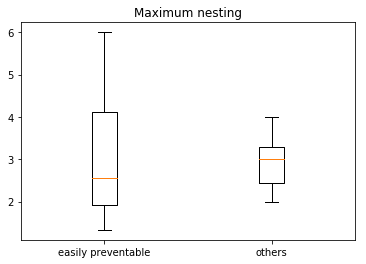

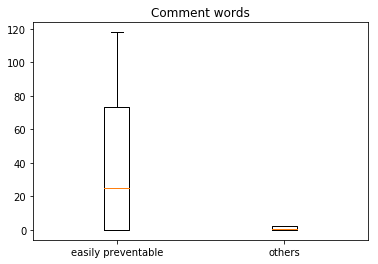

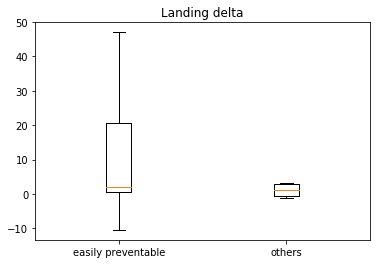

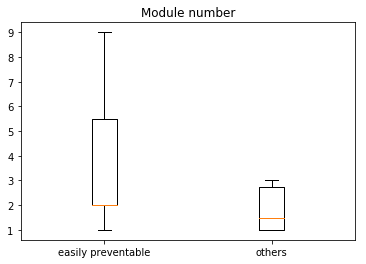

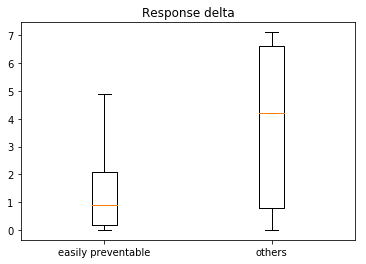

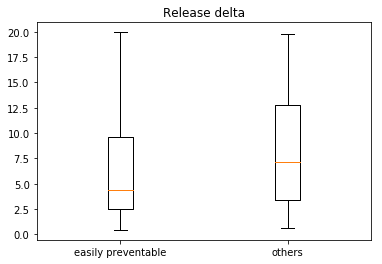

                 metric  easily preventable    others  p-value
0            Code churn              189.00    154.50     1.00
1            Test churn                0.00      0.00     1.00
2         Prior changes              474.00    257.50     1.00
3    Average cyclomatic                3.00      2.58     1.00
4   Number of functions               32.47     45.82     1.00
5         Comment ratio                0.18      0.15     1.00
6             Closeness                1.59      1.70     1.00
7           Betweenness            38611.34  27445.30     1.00
8              PageRank                1.70      2.36     1.00
9         Release delta                4.36      7.14     1.00
10   Number of comments               22.00     32.00     1.00
11       Developer exp.               46.50     37.50     1.00
12        Reviewer exp.               48.00     26.50     1.00
13      Review duration               15.42     18.58     1.00
14  Developer sentiment               -3.00     -3.00  

In [10]:
df_beta = pd.read_csv('regressions_shipped_to_users_beta_clean.csv')
easily_preventable_beta1 = df_beta[
    (df_beta[u'how_found'] == 'found on a widely used feature/website/config') &
    ((df_beta[u'reproducible'] == 'reproducible') | (df_beta[u'reproducible'] == 'reproducible (but not by everyone)'))
] 
easily_preventable_beta2 = df_beta[
    (df_beta[u'how_found'] == 'found via telemetry') &
    ((df_beta[u'reproducible'] == 'not reproducible') | (df_beta[u'reproducible'] == 'not reproducible (except by reporter)'))
]

df_input = pd.concat([easily_preventable_beta1,easily_preventable_beta2])
df_input.rename(columns={'uplift_id':'bug_id'}, inplace=True)
df_sub1, df_sub2 = subCategories(df, df_input, 'reproducible', 'reproducible')

outputResults(df_sub1, df_sub2, 'easily preventable')

In [11]:
def partiallyFixed(filename):
    partially_fixed_bugs = set()
    with open('reoccurrence/%s' %filename) as f:
        reader = csv.reader(f)
        for row in reader:
            if 'partially fixed' in row[-2]:
                partially_fixed_bugs.add(int(row[0]))
    return partially_fixed_bugs

In [12]:
partially_fixed_bugs = partiallyFixed('additionally_uplifted_with_channels.csv')
partially_fixed_bugs |= partiallyFixed('bm25_opened_after_with_channels.csv')
partially_fixed_bugs |= partiallyFixed('bm25_resolved_after_with_channels.csv')
partially_fixed_bugs |= partiallyFixed('cloned_with_channels.csv')
partially_fixed_bugs |= partiallyFixed('reopened_with_channels.csv')

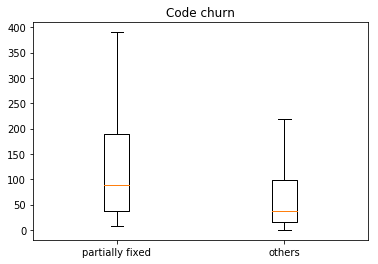

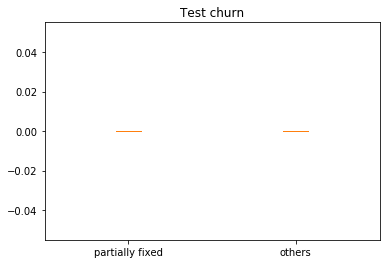

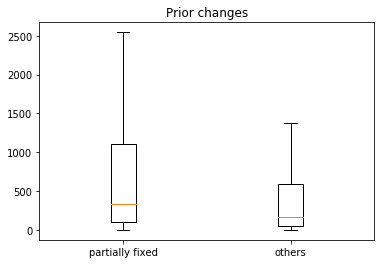

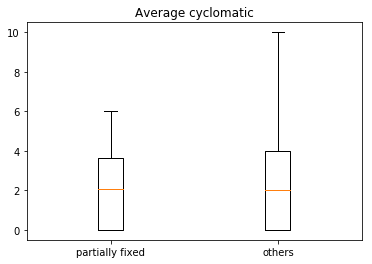

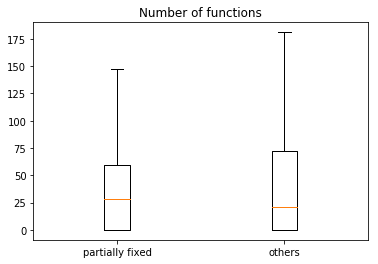

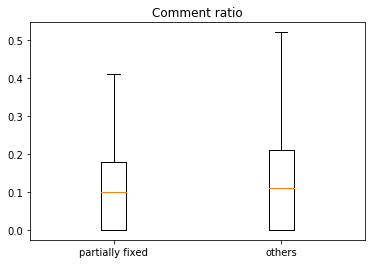

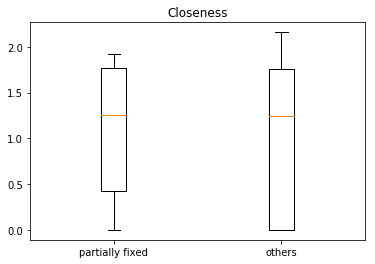

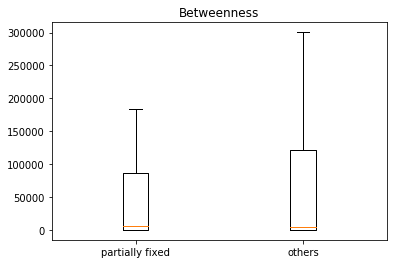

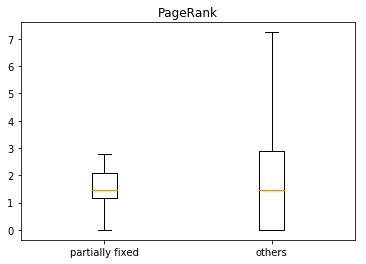

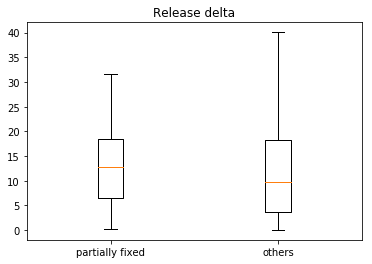

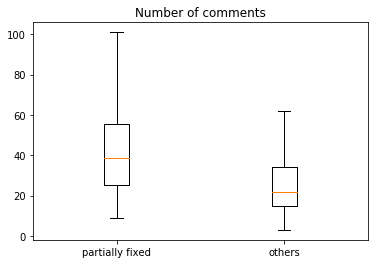

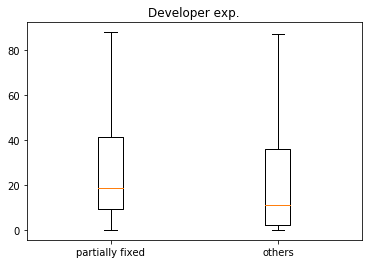

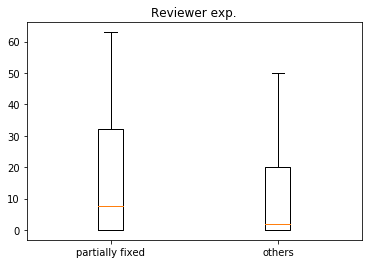

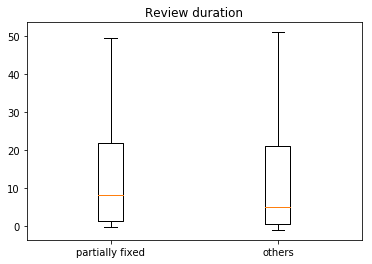

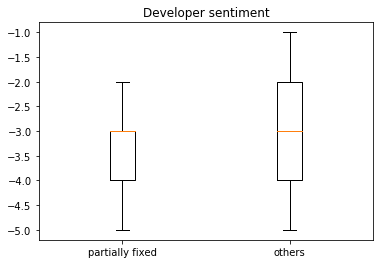

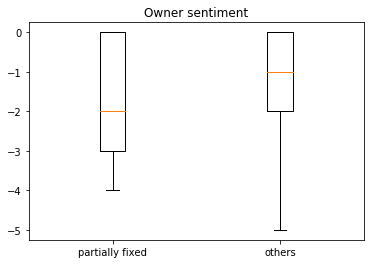

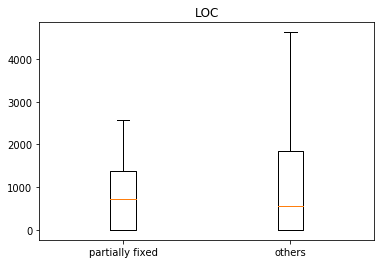

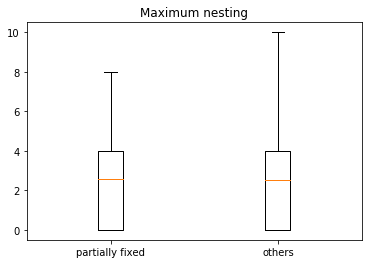

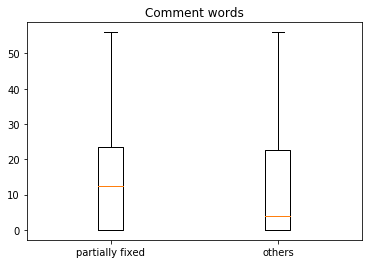

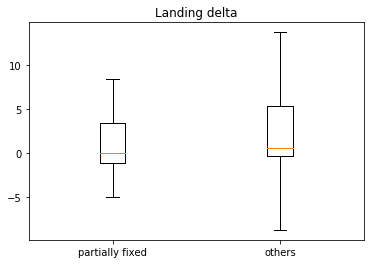

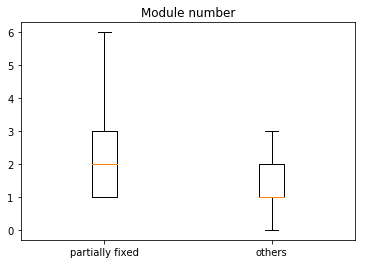

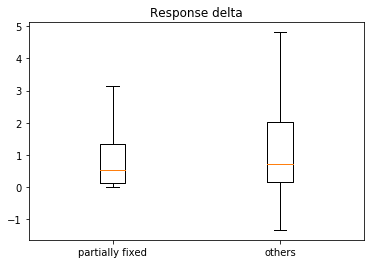

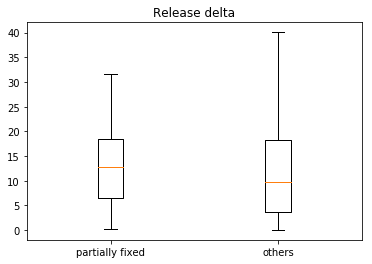

                 metric  partially fixed   others  p-value
0            Code churn            88.50    37.00     0.00
1            Test churn             0.00     0.00     0.35
2         Prior changes           328.00   163.00     0.63
3    Average cyclomatic             2.08     2.00     1.00
4   Number of functions            28.20    21.24     1.00
5         Comment ratio             0.10     0.11     1.00
6             Closeness             1.26     1.24     1.00
7           Betweenness          6370.82  3710.38     1.00
8              PageRank             1.44     1.45     1.00
9         Release delta            12.71     9.71     1.00
10   Number of comments            38.50    22.00     0.00
11       Developer exp.            18.50    11.00     0.23
12        Reviewer exp.             7.50     2.00     1.00
13      Review duration             8.26     4.98     1.00
14  Developer sentiment            -3.00    -3.00     0.53
15      Owner sentiment            -2.00    -1.00     1.

In [13]:
df_sub1 = df[df['bug_id'].isin(partially_fixed_bugs)]
df_sub2 = df[~df['bug_id'].isin(partially_fixed_bugs)]


outputResults(df_sub1, df_sub2, 'partially fixed')